In [107]:
import os 
import sys

running_path = "/Odyssey/private/o23gauvr/code/FASCINATION/"
os.chdir(running_path)
sys.path.insert(0,running_path)

In [108]:


import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from sklearn.decomposition import PCA
import numpy as np
import scipy.ndimage
from tqdm import tqdm
from pathlib import Path
import src.utils as utils 
from scipy.ndimage import convolve
from scipy.signal import medfilt
import copy
from omegaconf import OmegaConf
from IPython.display import Markdown, display
import yaml
import copy
from tqdm import tqdm
import torch
import numpy as np
from scipy.ndimage import median_filter, uniform_filter
import scipy.signal as signal




In [109]:
plt.style.use('ggplot')

In [110]:
cmap = plt.get_cmap('viridis')

In [111]:
gpu = 0
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [112]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = {}
    n_components = 0
    print("Initializing datamodule")

Not reloading datamodule


In [113]:
save_fig = False

In [114]:
load_pca = True

In [115]:
norm = False

In [116]:
with open(f"pickle/rmse_ssp_pca_on_dm_3D_norm_False.pkl", "rb") as file:
    old_pca_rmse_dict = pickle.load(file)  

In [117]:
if load_pca:
    with open(f"/Odyssey/private/o23gauvr/code/FASCINATION/pickle/rmse_pca_all_components_with_pooling_upsampling_unorm_sklearn_pca.pkl", "rb") as file:
        pca_rmse_dict = pickle.load(file)  
        
else:
    pca_rmse_dict = {}
    

In [118]:
pca_n_layers = 5 #Number of layers to keep for the PCA


# Functions

In [119]:
def get_min_max_idx(arr,axs=1, pad=True):
    grad = np.diff(arr,axis=axs)
    grad_sign = np.sign(grad)
    min_max = np.diff(grad_sign,axis=axs) 
    min_max = np.abs(np.sign(min_max))
    if pad:
        min_max = np.pad(min_max, ((0,0),(1,1),(0,0),(0,0)), 'constant', constant_values=1)
    return min_max


In [120]:
def calculate_confusion_matrix_and_f1_score(min_max_idx_truth, min_max_idx_ae, axs=1, as_ratio=False):
    # Define the kernel based on the shape of the truth array
    kernel_shape = [1] * min_max_idx_truth.ndim
    kernel_shape[axs] = 10  # Set the size of the kernel along the specified axis
    kernel = np.ones(kernel_shape)

    # Expand the truth array with the kernel
    truth_expanded = convolve(min_max_idx_truth, kernel, mode='constant', cval=0.0)
    ae_expanded = convolve(min_max_idx_ae, kernel, mode='constant', cval=0.0)

    # Compute the true positives
    true_positives = (truth_expanded > 0) & (min_max_idx_ae > 0)
    num_true_positives = np.sum(true_positives)

    # Compute the false positives
    false_positives = (truth_expanded == 0) & (min_max_idx_ae > 0)
    num_false_positives = np.sum(false_positives)

    # Compute the true negatives
    true_negatives = (min_max_idx_truth == 0) & (min_max_idx_ae == 0)
    num_true_negatives = np.sum(true_negatives)

    # Compute the false negatives
    false_negatives = (min_max_idx_truth > 0) & (ae_expanded == 0)
    num_false_negatives = np.sum(false_negatives)

    # Create the confusion matrix
    confusion_matrix = np.array([[num_true_negatives, num_false_positives],
                                 [num_false_negatives, num_true_positives]])

    if as_ratio:
        total = np.sum(confusion_matrix)
        confusion_matrix = confusion_matrix / total

    precision_score = num_true_positives / (num_true_positives + num_false_positives)
    recall_score = num_true_positives / (num_true_positives + num_false_negatives)
    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return confusion_matrix, f1_score

# RMSE

In [121]:

ckpt_dict = {}

base_dir = "/Odyssey/private/o23gauvr/code/FASCINATION/outputs/visualisation"


# List the first-level directories in the base directory
first_level_dirs = next(os.walk(base_dir))[1]

# Iterate through the first-level directories
for dir_name in first_level_dirs:
    if dir_name == "mute":
        continue
    # Create the relative path
    relative_path = os.path.join(base_dir, dir_name)
    # Add to the dictionary
    ckpt_dict[dir_name] = relative_path

# Print the dictionary
print(ckpt_dict)


{'AE_dense_0_pool': '/Odyssey/private/o23gauvr/code/FASCINATION/outputs/visualisation/AE_dense_0_pool'}


In [122]:
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))
    print(f"Model {model_carac} with {len(ckpt_list)} checkpoints")

Model AE_dense_0_pool with 8 checkpoints


In [ ]:
from scipy.signal import butter, filtfilt

params = {
    "filtering": True,
    "kernel": 3,  # This will be used as Wn for Butterworth filter
    "mode": "mean"  # options: "median", "mean", "butterworth"
}

verbose = True

ae_rmse_dict = {"SSP":{},
                "ECS":{},
                "mean_error_n_min_max":{},
                "conf_matrix":{},
                "F1_score":{}}

if params["filtering"]:
    filtered_ae_rmse_dict = copy.deepcopy(ae_rmse_dict)

for model_carac in ckpt_dict.keys():
    ckpt_list = list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))

    for ckpt_path in tqdm(ckpt_list):
        ckpt_path = str(ckpt_path)
        
        model_name = " ".join((ckpt_path.split("AE")[-1]).split("/")).replace("_", "  ")
        print(f"\n{model_name}")

        if model_carac not in ae_rmse_dict["SSP"].keys():
            for sub_dic in ae_rmse_dict.values():
                sub_dic[model_carac] = {}

            if params["filtering"]:
                for sub_dic in filtered_ae_rmse_dict.values():
                    sub_dic[model_carac] = {}

        try:
            cfg = utils.get_cfg_from_ckpt_path(ckpt_path, pprint=False)
        except:
            print(f"Can't load config")
            continue

        if cfg.datamodule in list(dm_dict.keys()):
            dm = dm_dict[cfg.datamodule]
            test_ssp_arr, _ = utils.loading_datamodule_phase(dm, phase="test")
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch, cfg.dtype), device=device)
        else:
            if verbose:
                print("Initiating datamodule; Generating train and test datasets")
            dm = hydra.utils.call(cfg.datamodule)
            test_ssp_arr, dm = utils.loading_datamodule_phase(dm, phase="test")
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch, cfg.dtype), device=device)
            dm_dict[cfg.datamodule] = dm

        input_test_shape = test_ssp_tens.shape
        depth_array = dm.depth_array

        if verbose:
            print("Loading model, generating AE output")

        try:
            lit_model = utils.load_model(ckpt_path, dm, device, verbose=True)
        except:
            print(f"Can't load model")
            continue

        ssp_ae_test_arr = lit_model(test_ssp_tens).detach().cpu().numpy().astype(test_ssp_arr.dtype)

        try:
            bottleneck_shape = lit_model.model_AE.bottleneck_shape
        except:
            bottleneck_shape = lit_model.encoder.net(test_ssp_tens.unsqueeze(1)).shape

        compression_rate_ae = test_ssp_tens.numel() / bottleneck_shape.numel()

        if bottleneck_shape in ae_rmse_dict["SSP"][model_carac].keys():
            continue

        if not norm:
            test_ssp_arr = utils.unorm_ssp_arr_3D(test_ssp_arr, dm)
            ssp_ae_test_arr = utils.unorm_ssp_arr_3D(ssp_ae_test_arr, dm)

        max_ssp_truth_idx = np.nanargmax(test_ssp_arr, axis=1)
        ecs_truth = depth_array[max_ssp_truth_idx]

        max_ssp_ae_idx = np.nanargmax(ssp_ae_test_arr, axis=1)
        ecs_pred_ae = depth_array[max_ssp_ae_idx]

        ae_ssp_rmse = np.sqrt(np.mean((test_ssp_arr - ssp_ae_test_arr) ** 2))
        ae_ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae) ** 2))

        min_max_idx_truth = get_min_max_idx(test_ssp_arr, pad=False)
        min_max_idx_ae = get_min_max_idx(ssp_ae_test_arr, pad=False)
        mean_error_n_min_max = np.mean(np.abs(np.sum(min_max_idx_truth, axis=1) - np.sum(min_max_idx_ae, axis=1)))

        conf_matrix_counts, F1_score = calculate_confusion_matrix_and_f1_score(min_max_idx_truth, min_max_idx_ae, as_ratio=False)

        ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
        ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse
        ae_rmse_dict["mean_error_n_min_max"][model_carac][bottleneck_shape] = mean_error_n_min_max
        ae_rmse_dict["conf_matrix"][model_carac][bottleneck_shape] = conf_matrix_counts
        ae_rmse_dict["F1_score"][model_carac][bottleneck_shape] = F1_score

        if params["filtering"]:
            if params["mode"] == "median":
                filtered_ae_test_arr = median_filter(ssp_ae_test_arr, size=(1, params["kernel"], 1, 1))
            elif params["mode"] == "mean":
                filtered_ae_test_arr = uniform_filter(ssp_ae_test_arr, size=(1, params["kernel"], 1, 1))
            elif params["mode"] == "butterworth":
                b, a = butter(N=2,Wn=params["kernel"], btype='low', analog=False)
                filtered_ae_test_arr = filtfilt(b, a, ssp_ae_test_arr, axis=1)

            max_ssp_ae_idx = np.nanargmax(filtered_ae_test_arr, axis=1)
            ecs_pred_ae = depth_array[max_ssp_ae_idx]
            ae_ssp_rmse = np.sqrt(np.mean((test_ssp_arr - filtered_ae_test_arr) ** 2))
            ae_ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae) ** 2))
            min_max_idx_ae = get_min_max_idx(filtered_ae_test_arr, pad=False)
            mean_error_n_min_max = np.mean(np.abs(np.sum(min_max_idx_truth, axis=1) - np.sum(min_max_idx_ae, axis=1)))

            conf_matrix_counts, F1_score = calculate_confusion_matrix_and_f1_score(min_max_idx_truth, min_max_idx_ae, as_ratio=False)

            filtered_ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
            filtered_ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse
            filtered_ae_rmse_dict["mean_error_n_min_max"][model_carac][bottleneck_shape] = mean_error_n_min_max
            filtered_ae_rmse_dict["conf_matrix"][model_carac][bottleneck_shape] = conf_matrix_counts
            filtered_ae_rmse_dict["F1_score"][model_carac][bottleneck_shape] = F1_score

        if verbose:
            print("bottleneck: ", bottleneck_shape)
            print("cr: ", compression_rate_ae)


  0%|          | 0/8 [00:00<?, ?it/s]


  dense  0  pool channels  [107, 100, 100, 100] upsample  mode  trilinear linear  layer  False cr  10000 2  conv  per  layer padding  cubic interp  size  0 final  upsample  upsample act  fn  Relu use  final  act  fn  True lr  0.01 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-24  18-29 checkpoints val  loss=0.01-epoch=145.ckpt


In [84]:
ae_rmse_dict

{'SSP': {'AE_dense_0_pool': {torch.Size([37, 100, 174, 240, 1]): 0.5403658,
   torch.Size([37, 10, 174, 240, 1]): 0.5437172,
   torch.Size([37, 2, 174, 240, 1]): 9.147314,
   torch.Size([37, 30, 174, 240, 1]): 0.5247537,
   torch.Size([37, 70, 174, 240, 1]): 0.52747136,
   torch.Size([37, 107, 174, 240, 1]): 0.53957844}},
 'ECS': {'AE_dense_0_pool': {torch.Size([37, 100, 174, 240, 1]): 50.54820692614743,
   torch.Size([37, 10, 174, 240, 1]): 54.281549995134895,
   torch.Size([37, 2, 174, 240, 1]): 203.42144914864767,
   torch.Size([37, 30, 174, 240, 1]): 51.88259340977795,
   torch.Size([37, 70, 174, 240, 1]): 49.07418894101306,
   torch.Size([37, 107, 174, 240, 1]): 51.06798013032655}},
 'mean_error_n_min_max': {'AE_dense_0_pool': {torch.Size([37, 100, 174, 240, 1]): 3.1739476,
   torch.Size([37, 10, 174, 240, 1]): 17.497746,
   torch.Size([37, 2, 174, 240, 1]): 1.056846,
   torch.Size([37, 30, 174, 240, 1]): 12.465869,
   torch.Size([37, 70, 174, 240, 1]): 5.7011013,
   torch.Size([3

In [85]:


# plt.plot(test_ssp_arr[10,:,10,10],dm.depth_array)
# plt.plot(ssp_ae_test_arr[10,:,10,10],dm.depth_array)

# plt.gca().invert_yaxis()
# x_min, x_max = plt.gca().get_xlim()
# non_zero_indices_truth = min_max_idx_truth[10,:,10,10] != 0
# non_zero_indices_ae = min_max_idx_ae[10,:,10,10] != 0

# plt.hlines(min_max_idx_truth[10,:,10,10][non_zero_indices_truth] * dm.depth_array[non_zero_indices_truth], x_min, x_max, colors="r")

# plt.hlines(min_max_idx_ae[10,:,10,10][non_zero_indices_ae] * dm.depth_array[non_zero_indices_ae], x_min, x_max, colors="b")



In [86]:
# if not load_pca:
#     train_ssp_arr, _, _, _, _ = loading_datamodule_phase(dm, phase = "fit")
#     input_train_shape = train_ssp_arr.shape

# if bottleneck_shape[2] != n_components and not load_pca:


#     n_components = bottleneck_shape[2]
#     compression_rate_pca = 107/n_components

#     if verbose:
#         print("training PCA, generating PCA output")    
        
#     pca = PCA(n_components = n_components, svd_solver = 'auto')
#     #pca.fit(train_ssp_arr.transpose(0,2,3,1).reshape(-1,107)) 

#     if norm:
#         ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(train_ssp_arr.transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)
    
#     else :
#         ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(unorm_ssp_arr_3D(train_ssp_arr).transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)

#     if ecs_algo == "first_max":
#         ecs_pred_pca = explicit_ecs_3D(torch.tensor(ssp_pca_test_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
    
#     elif ecs_algo == "max":
#         max_ssp_pca_idx = np.nanargmax(ssp_pca_test_arr, axis=1)
#         ecs_pred_pca = depth_array[max_ssp_pca_idx]
        

#     pca_ssp_rmse_dict[n_components] = np.sqrt(np.mean((test_ssp_arr - ssp_pca_test_arr)**2))
    
#     pca_ecs_rmse_dict[n_components]  = np.sqrt(np.mean((ecs_truth - ecs_pred_pca)**2))
    

## add specific model

In [87]:
if dm_dict == {}:
    cfg_path = "config/xp/autoencoder_V2.yaml"
    cfg = OmegaConf.load(cfg_path)
    display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))

    dm = hydra.utils.instantiate(cfg.datamodule)
    #_, test_ssp_tens, dm = loading_datamodule_phase(dm, phase = "test")
    dm.setup("test")


    ae_rmse_dict = {"SSP":{},
                    "ECS":{},
                    "mean_error_n_min_max":{},
                    "conf_matrix":{},
                    "F1_score":{}}


In [88]:

# ae_rmse_dict = {"SSP":{},
#                 "ECS":{}}

# pickle_data_path_list = ["pickle/pooling_upsampling_pca_pre_treatment_rmse_norm_False.pkl"]
# pca_key = [30, 50, 100, 107]
# new_data = {}
# for data_path in pickle_data_path_list:
#     with open(data_path, "rb") as file:
#         new_data = pickle.load(file)

# for key in list(new_data["SSP"].keys()):
#     if any(key.endswith(f"_{num}") for num in pca_key):
#         ae_rmse_dict["SSP"][key] = new_data["SSP"][key]
#         ae_rmse_dict["ECS"][key] = new_data["ECS"][key]


# Plot

In [89]:
components_sorted_ae_rmse_dict = {"SSP":{},
                       "ECS":{},
                       "Filtered SSP": {},
                       "Filtered ECS": {},
                       "ECS max": {},
                       "Filtered ECS max": {}}

for model in ae_rmse_dict["SSP"].keys():
    
    sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    sorted_components = [key[2] if len(key)==5 else key[1] for key in sorted_keys]
    components_sorted_ae_rmse_dict["SSP"][model] = (sorted_components, [ae_rmse_dict["SSP"][model][key] for key in sorted_keys])
    components_sorted_ae_rmse_dict["ECS"][model] = (sorted_components, [ae_rmse_dict["ECS"][model][key] for key in sorted_keys])


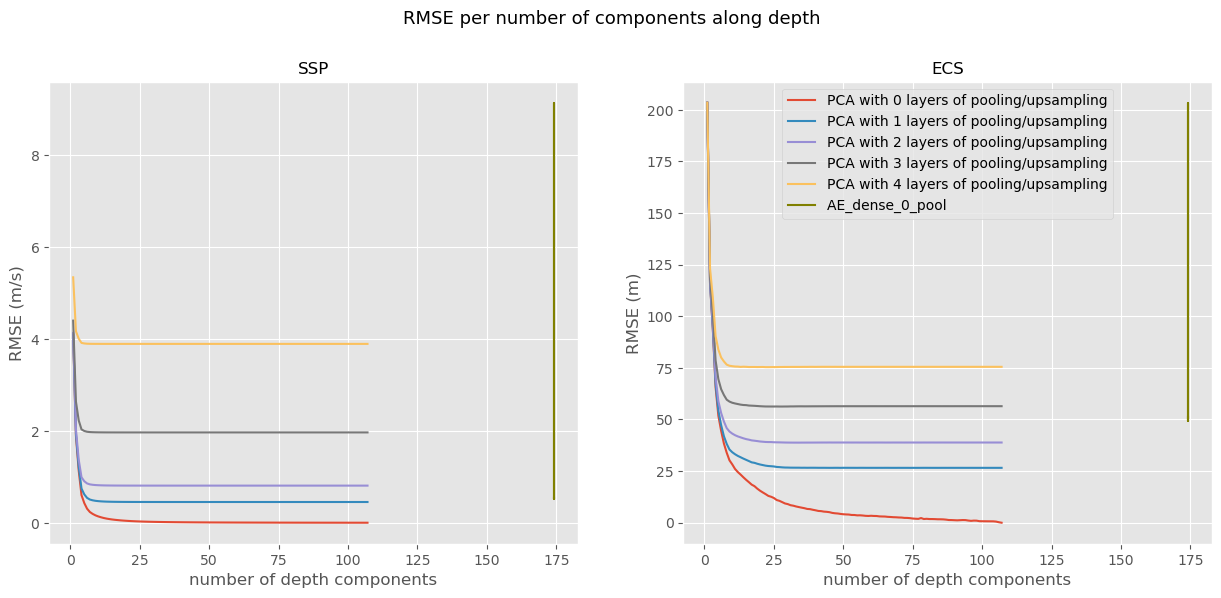

In [90]:

colors = ['olive', 'mediumblue', 'orchid', 'coral',
          'tomato','lightskyblue', 'mediumseagreen',
          'orange','yellowgreen', 'deepskyblue', 'navy', 
          'gold', 'dodgerblue', 'royalblue', 
          ]

fig,axs = plt.subplots(1,2,figsize=(15,6))



for n in range(pca_n_layers):

    if pca_n_layers == 1:
        label = "PCA"
    else:
        label = f"PCA with {n} layers of pooling/upsampling"

    axs[0].plot(pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].keys(),pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), label = label)
    axs[1].plot(pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].keys(),pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), label = label)

i = 0

for model in components_sorted_ae_rmse_dict["SSP"].keys():
        
    
    if len(components_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(components_sorted_ae_rmse_dict["SSP"][model][0], components_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(components_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(components_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}, explicit model")  # s adjusts the cross size
        axs[1].hlines(components_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(components_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i = i+1     
        
    

        
    
    else:

        axs[0].plot(components_sorted_ae_rmse_dict["SSP"][model][0],components_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model} ")

        i=i+1
        



if norm:
    axs[0].set_ylabel("RMSE (normalized)")  
else:    
    axs[0].set_ylabel("RMSE (m/s)")  

axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper right", prop={'size': 8})    
    
if norm: 
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("ECS",fontsize = 12)  
else:   
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  


# Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 8
elif len(labels) > 5:
    legend_fontsize = 10
else:
    legend_fontsize = 13

axs[1].legend(prop={'size': legend_fontsize})
        
for ax in axs:
    ax.set_xlabel("number of depth components")
    


    
fig_title = f"RMSE per number of components along depth"
fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

In [91]:
pca_cr_dict = {}
for model in pca_rmse_dict["lat_lon_shape"].keys():
    reduced_lat,reduced_lon = pca_rmse_dict["lat_lon_shape"][model][-2:]
    spatial_cr = dm.test_shape[2]*dm.test_shape[3]/(reduced_lat*reduced_lon)
    pca_cr_dict[model] = [spatial_cr*dm.test_shape[1]/n for n in range(1,dm.test_shape[1]+1)] 


In [92]:

cr_sorted_ae_rmse_dict = {"SSP":{},
                          "ECS":{},
                          "mean_error_n_min_max":{},
                          "F1_score":{}}

for model in ae_rmse_dict["SSP"].keys():
    
    cr_key_dict = {np.prod(dm.test_shape)/key.numel(): key for key in ae_rmse_dict["SSP"][model].keys()}
    sorted_cr_key = sorted(cr_key_dict.keys())
    
    # sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    # sorted_components = [key[2] for key in sorted_keys]
    cr_sorted_ae_rmse_dict["SSP"][model] = (sorted_cr_key, [ae_rmse_dict["SSP"][model][cr_key_dict[key]] for key in sorted_cr_key])
    cr_sorted_ae_rmse_dict["ECS"][model] = (sorted_cr_key, [ae_rmse_dict["ECS"][model][cr_key_dict[key]] for key in sorted_cr_key])
    cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model] = (sorted_cr_key, [ae_rmse_dict["mean_error_n_min_max"][model][cr_key_dict[key]] for key in sorted_cr_key])
    cr_sorted_ae_rmse_dict["F1_score"][model] = (sorted_cr_key, [ae_rmse_dict["F1_score"][model][cr_key_dict[key]] for key in sorted_cr_key])
     

if params["filtering"]:

    
    filtered_cr_sorted_ae_rmse_dict = {"SSP":{},
                                       "ECS":{},
                                       "mean_error_n_min_max":{},
                                       "F1_score":{}}

    for model in filtered_ae_rmse_dict["SSP"].keys():
        
        cr_key_dict = {np.prod(dm.test_shape)/key.numel(): key for key in filtered_ae_rmse_dict["SSP"][model].keys()}
        sorted_cr_key = sorted(cr_key_dict.keys())
        
        # sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
        # sorted_components = [key[2] for key in sorted_keys]
        filtered_cr_sorted_ae_rmse_dict["SSP"][model] = (sorted_cr_key, [filtered_ae_rmse_dict["SSP"][model][cr_key_dict[key]] for key in sorted_cr_key])
        filtered_cr_sorted_ae_rmse_dict["ECS"][model] = (sorted_cr_key, [filtered_ae_rmse_dict["ECS"][model][cr_key_dict[key]] for key in sorted_cr_key])
        filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model] = (sorted_cr_key, [filtered_ae_rmse_dict["mean_error_n_min_max"][model][cr_key_dict[key]] for key in sorted_cr_key])
        filtered_cr_sorted_ae_rmse_dict["F1_score"][model] = (sorted_cr_key, [filtered_ae_rmse_dict["F1_score"][model][cr_key_dict[key]] for key in sorted_cr_key])

0


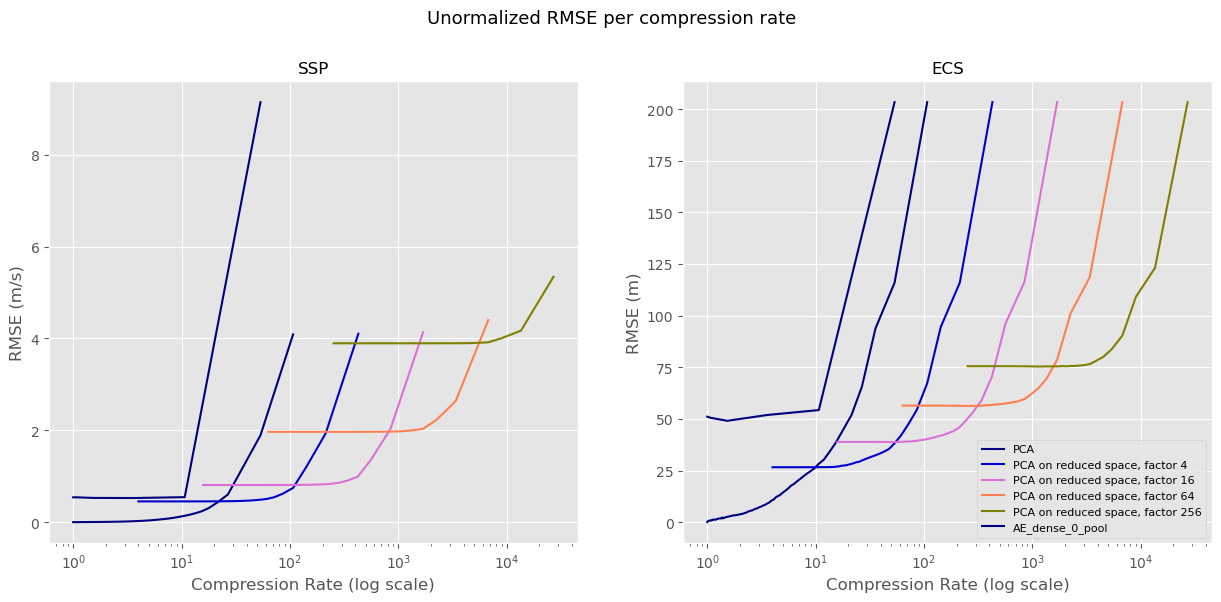

In [93]:
ecs_max = False

colors = ['navy', 'mediumblue', 'orchid', 'coral',
            'olive', 'mediumseagreen',
            'tomato','yellowgreen', 'deepskyblue', 
            'orange', 'dodgerblue', 'royalblue', 
            ]

fig,axs = plt.subplots(1,2,figsize=(15,6))

i=0

for n in range(pca_n_layers):
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    axs[0].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)
    axs[1].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)

    i = i+1


i=0


for model in cr_sorted_ae_rmse_dict["SSP"].keys():
    
    print(i)
    
    
    if len(cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(cr_sorted_ae_rmse_dict["SSP"][model][0], cr_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(cr_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(cr_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[1].hlines(cr_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(cr_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        
            


    
    else:

        axs[0].plot(cr_sorted_ae_rmse_dict["SSP"][model][0],cr_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model}")

        i=i+1
        
        
        if ecs_max:
            axs[1].plot(cr_sorted_ae_rmse_dict["ECS max"][model][0], cr_sorted_ae_rmse_dict["ECS max"][model][1], c = colors[i], label = f"{model} max algo")

            i=i+1
            

                




axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper left", prop={'size': 8})    


if norm: 
    axs[0].set_ylabel("RMSE")  
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("ECS",fontsize = 12)  
    fig_title = f"Normalized RMSE per compression rate"
    
else:   
    axs[0].set_ylabel("RMSE (m/s)")  
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  
    fig_title = f"Unormalized RMSE per compression rate"


    # Adjust the legend size based on the number of labels
    handles, labels = axs[1].get_legend_handles_labels()
    if len(labels) > 10:
        legend_fontsize = 7
    elif len(labels) > 5:
        legend_fontsize = 8
    else:
        legend_fontsize = 10

    axs[1].legend(prop={'size': legend_fontsize})
            
for ax in axs:

    ax.set_xlabel("Compression Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

# PCA versus dense 

select PCA layer 

In [94]:
pca_layer = [0,1,2,3]

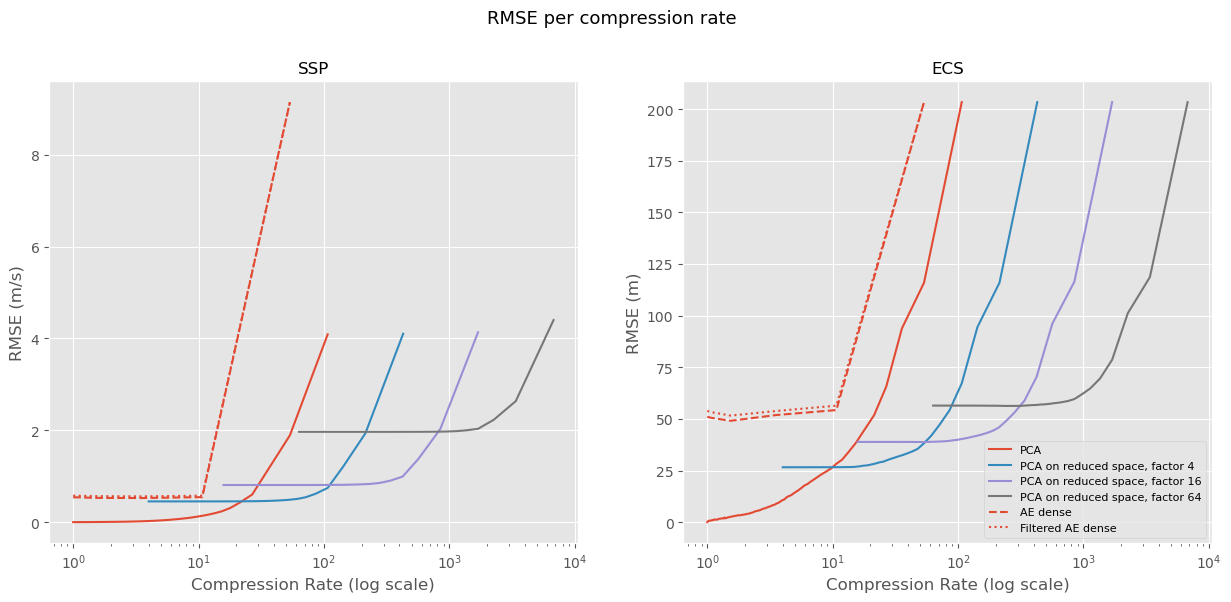

In [95]:
ecs_max = False

# colors = ['navy', 'orchid', 'coral',
#           'tomato','olive', 'mediumseagreen',
#           'mediumblue','yellowgreen', 'deepskyblue',
#             'orange', 'dodgerblue', 'royalblue' ]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


fig,axs = plt.subplots(1,2,figsize=(15,6))

i=0

for n in pca_layer:
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    axs[0].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)
    axs[1].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)

    i = i+1


i=0

layer_cr_sorted_ae_rmse_dict = sorted(cr_sorted_ae_rmse_dict["SSP"].keys())


for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
    if n == 0:
        label = "AE dense"
    else:
        label = f"AE dense on reduced space, factor {4**n}"
    
    
    if len(cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        axs[0].scatter(cr_sorted_ae_rmse_dict["SSP"][model][0], cr_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(cr_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(cr_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[1].hlines(cr_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(cr_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        

    
    else:

        axs[0].plot(cr_sorted_ae_rmse_dict["SSP"][model][0],cr_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], ls='--', label = label)
        
        axs[1].plot(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i],ls='--', label = label)

        i=i+1
        

i=0


if params["filtering"]:

    for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
        if n == 0:
            label = "Filtered AE dense"
        else:
            label = f"Filtered AE dense on reduced space, factor {4**n}"
        
        
        if len(filtered_cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
            
            axs[0].scatter(filtered_cr_sorted_ae_rmse_dict["SSP"][model][0], filtered_cr_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
            axs[0].hlines(filtered_cr_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=filtered_cr_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
            axs[0].vlines(filtered_cr_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=filtered_cr_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

            axs[1].scatter(filtered_cr_sorted_ae_rmse_dict["ECS"][model][0], filtered_cr_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
            axs[1].hlines(filtered_cr_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=filtered_cr_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
            axs[1].vlines(filtered_cr_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=filtered_cr_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
            
            i=i+1    
            

        
        else:

            axs[0].plot(filtered_cr_sorted_ae_rmse_dict["SSP"][model][0],filtered_cr_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], ls=':', label = label)
            
            axs[1].plot(filtered_cr_sorted_ae_rmse_dict["ECS"][model][0], filtered_cr_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i],ls=':', label = label)

            i=i+1


                




axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper left", prop={'size': 8})    



axs[0].set_ylabel("RMSE (m/s)")  
axs[1].set_ylabel("RMSE (m)")  
axs[1].set_title("ECS",fontsize = 12)  
fig_title = f"RMSE per compression rate"


# Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 7
elif len(labels) > 5:
    legend_fontsize = 8
else:
    legend_fontsize = 10

axs[1].legend(prop={'size': legend_fontsize})
        
for ax in axs:

    ax.set_xlabel("Compression Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

# Min max detection

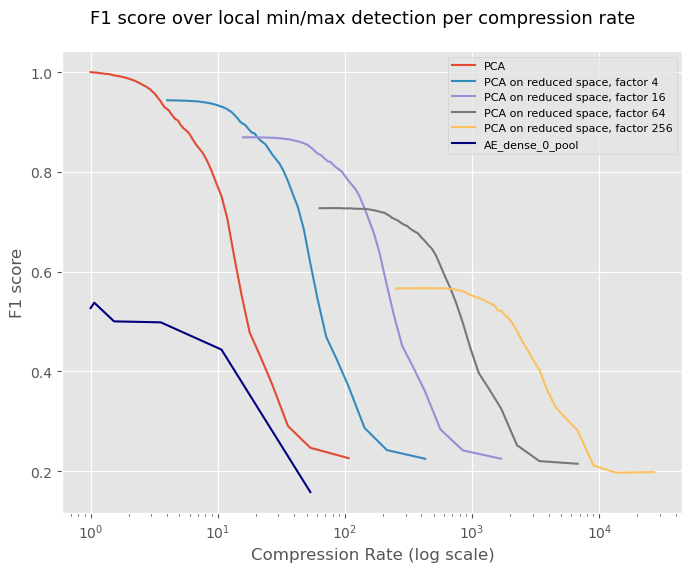

In [96]:
ecs_max = False

colors = ['navy', 'mediumblue', 'orchid', 'olive',
            'coral', 'mediumseagreen',
            'tomato','yellowgreen', 'deepskyblue', 
            'orange', 'dodgerblue', 'royalblue', 
            ]

fig,ax = plt.subplots(1,1,figsize=(8,6))


for n in range(pca_n_layers):
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    ax.plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["F1_score"][f"Pool_upsample_{n}_layers"].values(), label = label)

i=0

for model in cr_sorted_ae_rmse_dict["SSP"].keys():
        
    
    if len(cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        
        ax.scatter(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        ax.hlines(cr_sorted_ae_rmse_dict["F1_score"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["F1_score"][model][0], colors=colors[i], linestyles='dashed')
        ax.vlines(cr_sorted_ae_rmse_dict["F1_score"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["F1_score"][model][1], colors=colors[i], linestyles='dashed')        

        i=i+1    
        
            


    
    else:

        ax.plot(cr_sorted_ae_rmse_dict["F1_score"][model][0],cr_sorted_ae_rmse_dict["F1_score"][model][1], c = colors[i], label = f"{model}")
        
        i=i+1
        
        
            

                




#axs[0].legend(loc = "upper left", prop={'size': 8})    



ax.set_ylabel("F1 score")  
fig_title = f"F1 score over local min/max detection per compression rate"
    


    # Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 7
elif len(labels) > 5:
    legend_fontsize = 8
else:
    legend_fontsize = 10

ax.legend(prop={'size': legend_fontsize})
            


ax.set_xlabel("Compression Rate (log scale)")
ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 0.95)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

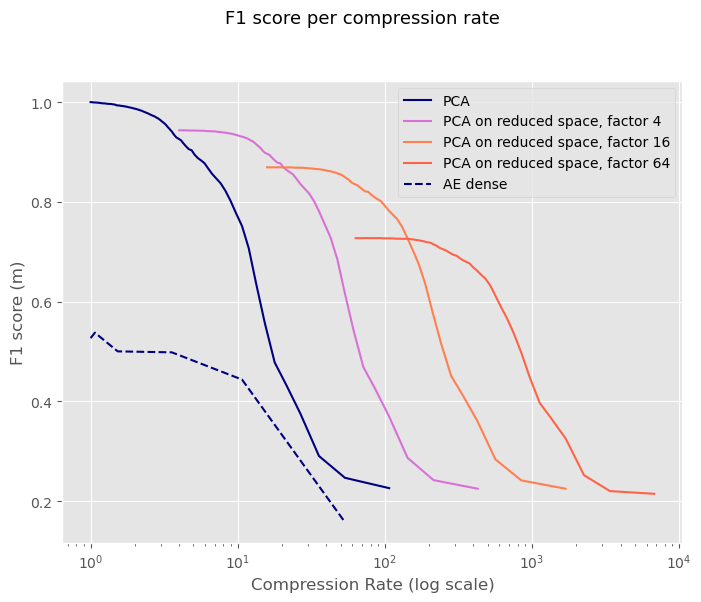

In [97]:
ecs_max = False

colors = ['navy', 'orchid', 'coral',
          'tomato','olive', 'mediumseagreen',
          'mediumblue','yellowgreen', 'deepskyblue',
            'orange', 'dodgerblue', 'royalblue' ]

fig,ax = plt.subplots(1,1,figsize=(8,6))

i=0

for n in pca_layer:
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    ax.plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["F1_score"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)

    i = i+1


i=0

layer_cr_sorted_ae_rmse_dict = sorted(cr_sorted_ae_rmse_dict["SSP"].keys())


for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
    if n == 0:
        label = "AE dense"
    else:
        label = f"AE dense on reduced space, factor {4**n}"
    
    
    if len(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0]) == 1:

        ax.scatter(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        ax.hlines(cr_sorted_ae_rmse_dict["F1_score"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["F1_score"][model][0], colors=colors[i], linestyles='dashed')
        ax.vlines(cr_sorted_ae_rmse_dict["F1_score"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["F1_score"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        
            


    
    else:
        
        ax.plot(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], c = colors[i],ls='--', label = label)

        i=i+1
        

 
    ax.set_ylabel("F1 score (m)")  
    fig_title = f"F1 score per compression rate"


    # Adjust the legend size based on the number of labels
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 10:
        legend_fontsize = 7
    elif len(labels) > 5:
        legend_fontsize = 8
    else:
        legend_fontsize = 10

    ax.legend(prop={'size': legend_fontsize})
            


    ax.set_xlabel("Compression Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

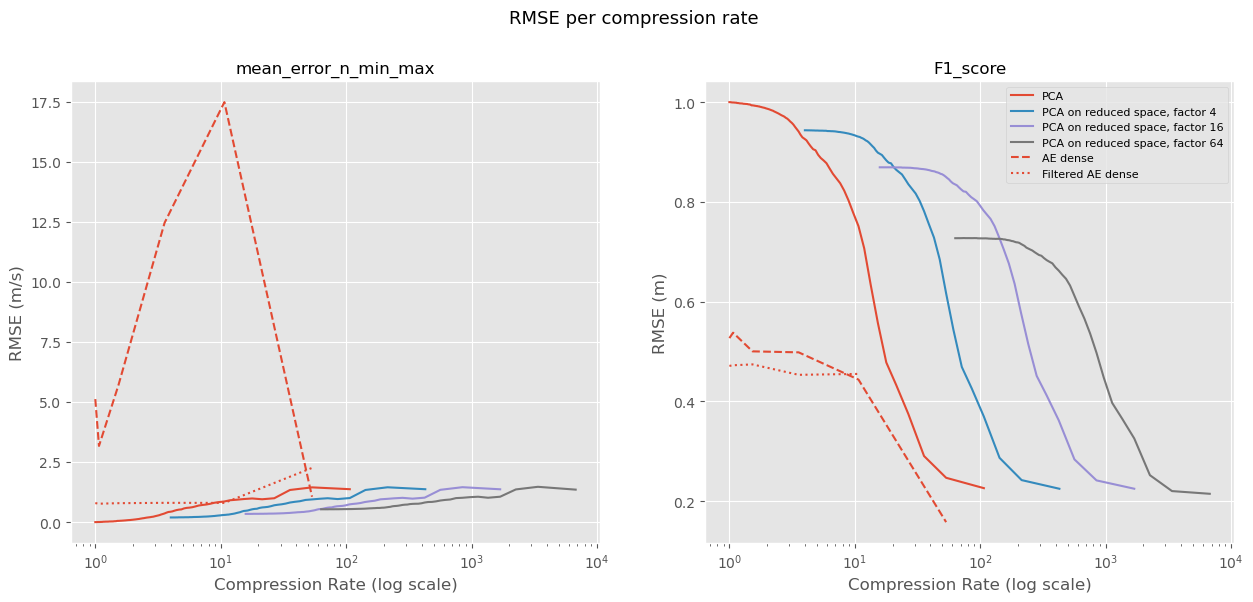

In [ ]:
F1_score_max = False

# colors = ['navy', 'orchid', 'coral',
#           'tomato','olive', 'mediumseagreen',
#           'mediumblue','yellowgreen', 'deepskyblue',
#             'orange', 'dodgerblue', 'royalblue' ]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


fig,axs = plt.subplots(1,2,figsize=(15,6))

i=0

for n in pca_layer:
    if n == 0:
        label = "PCA"
    else:
        label = f"PCA on reduced space, factor {4**n}"

    axs[0].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["mean_error_n_min_max"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)
    axs[1].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["F1_score"][f"Pool_upsample_{n}_layers"].values(), color=colors[i], label = label)

    i = i+1


i=0

layer_cr_sorted_ae_rmse_dict = sorted(cr_sorted_ae_rmse_dict["mean_error_n_min_max"].keys())


for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
    if n == 0:
        label = "AE dense"
    else:
        label = f"AE dense on reduced space, factor {4**n}"
    
    
    if len(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0]) == 1:
        
        axs[0].scatter(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[1].hlines(cr_sorted_ae_rmse_dict["F1_score"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["F1_score"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(cr_sorted_ae_rmse_dict["F1_score"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["F1_score"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        

    
    else:

        axs[0].plot(cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0],cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], c = colors[i], ls='--', label = label)
        
        axs[1].plot(cr_sorted_ae_rmse_dict["F1_score"][model][0], cr_sorted_ae_rmse_dict["F1_score"][model][1], c = colors[i],ls='--', label = label)

        i=i+1
        

i=0


if params["filtering"]:

    for n, model in enumerate(layer_cr_sorted_ae_rmse_dict):
    
        if n == 0:
            label = "Filtered AE dense"
        else:
            label = f"Filtered AE dense on reduced space, factor {4**n}"
        
        
        if len(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0]) == 1:
            
            axs[0].scatter(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
            axs[0].hlines(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], xmin=0, xmax=filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], colors=colors[i], linestyles='dashed')
            axs[0].vlines(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0], ymin=0, ymax=filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], colors=colors[i], linestyles='dashed')        

            axs[1].scatter(filtered_cr_sorted_ae_rmse_dict["F1_score"][model][0], filtered_cr_sorted_ae_rmse_dict["F1_score"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
            axs[1].hlines(filtered_cr_sorted_ae_rmse_dict["F1_score"][model][1], xmin=0, xmax=filtered_cr_sorted_ae_rmse_dict["F1_score"][model][0], colors=colors[i], linestyles='dashed')
            axs[1].vlines(filtered_cr_sorted_ae_rmse_dict["F1_score"][model][0], ymin=0, ymax=filtered_cr_sorted_ae_rmse_dict["F1_score"][model][1], colors=colors[i], linestyles='dashed')    
            
            i=i+1    
            

        
        else:

            axs[0].plot(filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][0],filtered_cr_sorted_ae_rmse_dict["mean_error_n_min_max"][model][1], c = colors[i], ls=':', label = label)
            
            axs[1].plot(filtered_cr_sorted_ae_rmse_dict["F1_score"][model][0], filtered_cr_sorted_ae_rmse_dict["F1_score"][model][1], c = colors[i],ls=':', label = label)

            i=i+1


                




axs[0].set_title("mean_error_n_min_max", fontsize = 12) 
#axs[0].legend(loc = "upper left", prop={'size': 8})    



axs[0].set_ylabel("RMSE (m/s)")  
axs[1].set_ylabel("RMSE (m)")  
axs[1].set_title("F1_score",fontsize = 12)  
fig_title = f"RMSE per compression rate"


# Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 7
elif len(labels) > 5:
    legend_fontsize = 8
else:
    legend_fontsize = 10

axs[1].legend(prop={'size': legend_fontsize})
        
for ax in axs:

    ax.set_xlabel("Compression Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

In [99]:
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(min_max_idx_truth.flatten(), min_max_idx_ae.flatten())

# fig, ax = plt.subplots(figsize=(10, 8))
# cax = ax.matshow(cm, cmap=plt.cm.Blues)
# fig.colorbar(cax)

# for (i, j), val in np.ndenumerate(cm):
#     ax.text(j, i, f'{val}', ha='center', va='center', color='red')

# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Local Min/Max Detection')
# plt.show()

In [100]:
ckpt_path = '/Odyssey/private/o23gauvr/code/FASCINATION/outputs/visualisation/AE_dense_0_pool/channels_[107, 100, 50, 30]/upsample_mode_trilinear/linear_layer_False/cr_10000/2_conv_per_layer/padding_cubic/interp_size_0/final_upsample_upsample/act_fn_Relu/use_final_act_fn_True/lr_0.001/normalization_mean_std/manage_nan_suppress/n_profiles_None/2025-01-24_14-40/checkpoints/val_loss=0.01-epoch=136.ckpt'


In [101]:
cfg = utils.get_cfg_from_ckpt_path(ckpt_path, pprint=False)
dm = hydra.utils.call(cfg.datamodule)

In [102]:
test_ssp_arr, dm = utils.loading_datamodule_phase(dm, phase = "test")

ssp_ae_test_arr = lit_model(test_ssp_tens).detach().cpu().numpy().astype(test_ssp_arr.dtype)  ##operation is too long on CPU

test_ssp_arr = utils.unorm_ssp_arr_3D(test_ssp_arr, dm)
ssp_ae_test_arr = utils.unorm_ssp_arr_3D(ssp_ae_test_arr, dm)
            

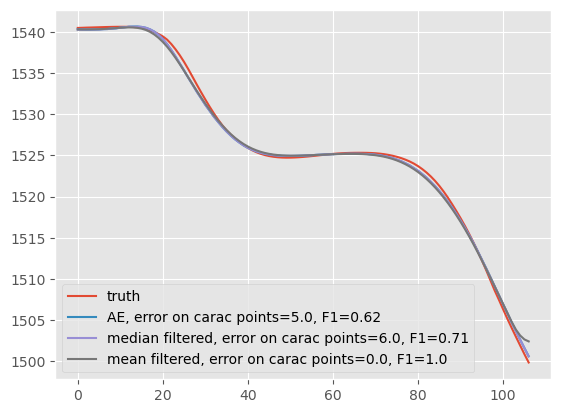

In [103]:
truth_pts = get_min_max_idx(test_ssp_arr[10,:,10,10], axs=0,pad=False)

ae_pts = get_min_max_idx(ssp_ae_test_arr[10,:,10,10], axs=0,pad=False)

plt.plot(test_ssp_arr[10,:,10,10], label = "truth")

conf_matrix_ae, F1_ae = calculate_confusion_matrix_and_f1_score(truth_pts, ae_pts, axs=0, as_ratio=False)
plt.plot(ssp_ae_test_arr[10,:,10,10], label = f"AE, error on carac points={np.abs(np.sum(truth_pts)-np.sum(ae_pts))}, F1={np.round(F1_ae,2)}")

median_filtered_ae = signal.medfilt(ssp_ae_test_arr[10,:,10,10], kernel_size=5)
median_pts = get_min_max_idx(median_filtered_ae, axs=0,pad=False)
median_conf_matrix_ae, median_F1_ae = calculate_confusion_matrix_and_f1_score(truth_pts, median_pts, axs=0, as_ratio=False)
plt.plot(median_filtered_ae, label = f"median filtered, error on carac points={np.abs(np.sum(truth_pts)-np.sum(median_pts))}, F1={np.round(median_F1_ae,2)}")

mean_filtered_ae = scipy.ndimage.uniform_filter1d(ssp_ae_test_arr[10,:,10,10], size=9)
mean_pts = get_min_max_idx(mean_filtered_ae, axs=0,pad=False)
mean_conf_matrix_ae, mean_F1_ae = calculate_confusion_matrix_and_f1_score(truth_pts, mean_pts, axs=0, as_ratio=False)
plt.plot(mean_filtered_ae, label = f"mean filtered, error on carac points={np.abs(np.sum(truth_pts)-np.sum(mean_pts))}, F1={np.round(mean_F1_ae,2)}")

plt.legend()
plt.show()

In [104]:
best_median_kernel = None
best_median_F1 = -1

best_mean_kernel = None
best_mean_F1 = -1

best_butter_F1 = -1
best_butter_Wn = None

kernel_sizes = tqdm(range(3, 25, 2))  # Example kernel sizes from 3 to 19
Wn_values = np.linspace(0.01, 0.5, 50)  # Example Wn values from 0.01 to 0.5
        
for kernel_size in kernel_sizes:
    # Median filter
    median_filtered_ae = signal.medfilt(ssp_ae_test_arr[10, :, 10, 10], kernel_size=kernel_size)
    median_pts = get_min_max_idx(median_filtered_ae, axs=0, pad=False)
    _, median_F1_ae = calculate_confusion_matrix_and_f1_score(truth_pts, median_pts, axs=0, as_ratio=False)
    
    if median_F1_ae > best_median_F1:
        best_median_F1 = median_F1_ae
        best_median_kernel = kernel_size

    # Mean filter
    mean_filtered_ae = scipy.ndimage.uniform_filter1d(ssp_ae_test_arr[10, :, 10, 10], size=kernel_size)
    mean_pts = get_min_max_idx(mean_filtered_ae, axs=0, pad=False)
    _, mean_F1_ae = calculate_confusion_matrix_and_f1_score(truth_pts, mean_pts, axs=0, as_ratio=False)
    
    if mean_F1_ae > best_mean_F1:
        best_mean_F1 = mean_F1_ae
        best_mean_kernel = kernel_size

for Wn in Wn_values:
    # Butterworth lowpass filter
    b, a = signal.butter(2, Wn, btype='low')
    butter_filtered_ae = signal.filtfilt(b, a, ssp_ae_test_arr[10, :, 10, 10])
    butter_pts = get_min_max_idx(butter_filtered_ae, axs=0, pad=False)
    _, butter_F1_ae = calculate_confusion_matrix_and_f1_score(truth_pts, butter_pts, axs=0, as_ratio=False)
    
    if butter_F1_ae > best_butter_F1:
        best_butter_F1 = butter_F1_ae
        best_butter_Wn = Wn

print(f"Best median filter kernel size: {best_median_kernel}, F1 score: {best_median_F1}")
print(f"Best mean filter kernel size: {best_mean_kernel}, F1 score: {best_mean_F1}")
print(f"Best Butterworth filter Wn: {best_butter_Wn}, F1 score: {best_butter_F1}")

  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_2412224/799727193.py:37: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
100%|██████████| 11/11 [00:00<00:00, 1955.39it/s]

Best median filter kernel size: 7, F1 score: 0.7692307692307693
Best mean filter kernel size: 7, F1 score: 1.0
Best Butterworth filter Wn: 0.060000000000000005, F1 score: 1.0



/tmp/ipykernel_2412224/799727193.py:35: RuntimeWarning: invalid value encountered in scalar divide
  precision_score = num_true_positives / (num_true_positives + num_false_positives)


In [105]:
# best_median_kernel = None
# best_median_F1 = -1

# best_mean_kernel = None
# best_mean_F1 = -1


# truth_pts = get_min_max_idx(test_ssp_arr[::5,:,::20,::20], axs=1,pad=False)
# ae_pts = get_min_max_idx(ssp_ae_test_arr[::5,:,::20,::20], axs=1,pad=False)

# conf_matrix_ae, F1_ae = calculate_confusion_matrix_and_f1_score(truth_pts, ae_pts, axs=1, as_ratio=False)

# kernel_sizes = tqdm(range(3, 25, 2) ) # Example kernel sizes from 3 to 19

# for kernel_size in kernel_sizes:
#     # Median filter
#     median_filtered_ae = signal.medfilt(ssp_ae_test_arr[::5,:,::20,::20], kernel_size=kernel_size)
#     median_pts = get_min_max_idx(median_filtered_ae, axs=1, pad=False)
#     _, median_F1_ae = calculate_confusion_matrix_and_f1_score(truth_pts, median_pts, axs=1, as_ratio=False)
    
#     if median_F1_ae > best_median_F1:
#         best_median_F1 = median_F1_ae
#         best_median_kernel = kernel_size

#     # Mean filter
#     mean_filtered_ae = scipy.ndimage.uniform_filter1d(ssp_ae_test_arr[::5,:,::20,::20], size=kernel_size)
#     mean_pts = get_min_max_idx(mean_filtered_ae, axs=1, pad=False)
#     _, mean_F1_ae = calculate_confusion_matrix_and_f1_score(truth_pts, mean_pts, axs=1, as_ratio=False)
    
#     if mean_F1_ae > best_mean_F1:
#         best_mean_F1 = mean_F1_ae
#         best_mean_kernel = kernel_size

# print(f"Best median filter kernel size: {best_median_kernel}, F1 score: {best_median_F1}")
# print(f"Best mean filter kernel size: {best_mean_kernel}, F1 score: {best_mean_F1}")

In [106]:


max_ssp_truth_idx = np.nanargmax(test_ssp_arr, axis=1)
ecs_truth = depth_array[max_ssp_truth_idx]

max_ssp_ae_idx = np.nanargmax(ssp_ae_test_arr, axis=1)
ecs_pred_ae = depth_array[max_ssp_ae_idx]
    
    
ae_ssp_rmse = np.sqrt(np.mean((test_ssp_arr - ssp_ae_test_arr)**2))
ae_ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae)**2))


min_max_idx_truth = get_min_max_idx(test_ssp_arr, pad=False)
min_max_idx_ae = get_min_max_idx(ssp_ae_test_arr, pad=False)
mean_error_n_min_max = np.mean(np.abs(np.sum(min_max_idx_truth, axis=1)-np.sum(min_max_idx_ae, axis=1)))

conf_matrix_counts, F1_score = calculate_confusion_matrix_and_f1_score(min_max_idx_truth, min_max_idx_ae, as_ratio=False)

        